In [1]:
from game import MOVES_FILE
import json
from x2 import make_state, apply_move, place
import numpy as np
from numpy.typing import NDArray
from typing import Tuple
from sklearn.model_selection import train_test_split

with open(MOVES_FILE, "r") as f:
    moves = [json.loads(l) for l in f.readlines()]

with open("moves1.jsonl", "r") as f:
    moves += [json.loads(l) for l in f.readlines()]


def map_move(move):
    before = np.array(move["before"])

    mx = before.max()
    offset = 0 if mx < 12 else mx - 12 + 1

    grid = np.where(before == 0, before, before - offset)

    if (grid < 0).any() or (grid > 12).any():
        return None

    next_value = move["next_value"] - offset
    if not (1 <= next_value <= 6):
        return None

    return {
        "before": grid.tolist(),
        "play": move["play"],
        "next_value": next_value,
    }


def check_move(move) -> bool:
    state = make_state(seed=0)
    state.grid = np.array(move["before"])

    mx = state.grid.max()
    offset = 0 if mx < 12 else mx - 12 + 1

    state.min = 1 + offset
    state.max = 6 + offset

    try:
        place(state, move["play"], move["next_value"])
    except:
        # print(move)
        return False

    return state.grid.tolist() == move["after"]


print(len(moves))

moves = [mapped for m in moves if check_move(m) and (mapped := map_move(m)) is not None]

len(moves)

505


467

In [2]:
def stack(flat, layers=12):
  """Convert an [5, 5] representation into [5, 5, layers] with one layers for each value."""
  # representation is what each layer represents
  representation = np.arange(layers, dtype=int) + 1

  # layered is the flat board repeated layers times
  layered = np.repeat(flat[:,:,:,np.newaxis], layers, axis=-1)

  # Now set the values in the board to 1 or zero depending whether they match representation.
  # Representation is broadcast across a number of axes
  layered = np.where(layered == representation, 1, 0)

  return layered

In [3]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

def moves_to_xy(moves: list): #-> Tuple[NDArray[np.float64], NDArray[np.float64]]:
    x1 = np.moveaxis(stack(np.array([m["before"] for m in moves])), -1, 1)

    print(x1.shape)

    y = np.array([int(m["play"]) for m in moves])

    x2 = get_one_hot(np.array([int(m["next_value"]) for m in moves]) - 1, 6) 

    # x = np.concatenate([all_next_value, all_befores], axis=1)
    return x1, x2, y

x1, x2, y = moves_to_xy(moves)

y_oh = get_one_hot(y, 5)

x1.shape, x2.shape, y_oh.shape

(467, 12, 5, 5)


((467, 12, 5, 5), (467, 6), (467, 5))

In [12]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader


class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(12, 12, 3),
            nn.ReLU(),

            nn.Conv2d(12, 12, 3),
            nn.ReLU(),

            nn.Flatten(),
        )

        self.mlp = nn.Sequential(
            nn.Linear(18, 16),
            nn.ReLU(),
            nn.Linear(16, 5),
        )

    def forward(self, x1, x2):
        conv_out = self.conv(x1)

        with_move = torch.concat((conv_out, x2), dim=1)

        logits = self.mlp(with_move)

        return logits

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = NeuralNetwork().to(device)
print(model)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

x1_train, x1_test, x2_train, x2_test, y_train, y_test = train_test_split(
    x1, x2, y_oh, random_state=0
)

X1 = torch.FloatTensor(x1_train).to(device)
X2 = torch.FloatTensor(x2_train).to(device)
y = torch.FloatTensor(y_train).to(device)

for e in range(2500):
    pred = model.forward(X1, X2)
    loss = loss_fn(pred, y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if (e + 1) % 250 == 0:
        print(f"epoch: {e+1}")
        print(f"loss: {loss.item():>7f}")

        preds: NDArray[np.float64] = (
            model.forward(
                torch.FloatTensor(x1_test).to(device),
                torch.FloatTensor(x2_test).to(device),
            )
            .detach()
            .cpu()
            .numpy()
        )
        val = (preds.argmax(axis=1) == y_test.argmax(axis=1)).mean()
        print(f"validation acc: {val}")

Using cuda device
NeuralNetwork(
  (conv): Sequential(
    (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp): Sequential(
    (0): Linear(in_features=18, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=5, bias=True)
  )
)
epoch: 250
loss: 0.658814
validation acc: 0.3076923076923077
epoch: 500
loss: 0.051295
validation acc: 0.2905982905982906
epoch: 750
loss: 0.012341
validation acc: 0.2905982905982906
epoch: 1000
loss: 0.007171
validation acc: 0.2905982905982906
epoch: 1250
loss: 0.005621
validation acc: 0.2905982905982906
epoch: 1500
loss: 0.004986
validation acc: 0.2905982905982906
epoch: 1750
loss: 0.004659
validation acc: 0.2905982905982906
epoch: 2000
loss: 0.004447
validation acc: 0.2905982905982906
epoch: 2250
loss: 0.004340
validation acc: 0.2905982905982906
epoch: 2500
loss: 0.004243
valid

In [7]:
import numpy as np

cpu_model = model.to("cpu")

def infer(grid: NDArray[np.float64], next_value: int) -> int:
    v = np.concatenate([[next_value], grid.ravel()]).reshape((1, -1))
    return cpu_model(torch.FloatTensor(v).to("cpu")).detach().cpu().numpy().argmax()

from typing import List
import numpy as np

rewards: List[int] = []

plays = []

for s in range(1000):
    state = make_state(seed=s)
    r = 0

    ps = []

    while True:

        move = infer(state.grid, state.next_play)
        ps.append(move)

        (state, reward, done) = apply_move(state, move)

        r += reward

        if done:
            rewards.append(r)
            plays.append(ps)
            break
            
np.mean(rewards), np.std(rewards)



TypeError: forward() missing 1 required positional argument: 'x2'

array([[<AxesSubplot:title={'center':'reward'}>]], dtype=object)

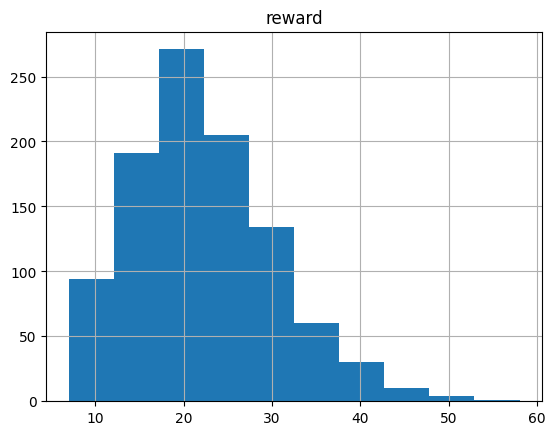

In [ ]:
import pandas as pd

df = pd.DataFrame(rewards, columns=['reward'])
df.hist()

In [ ]:
state = make_state(seed=2)
moves = plays[2]

r = 0

for m in moves:

    (state, reward, done) = apply_move(state, m)

    r += reward


print(r)

40
